In [1]:
import random
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve

In [2]:
# from stackoverflow :)
# https://stackoverflow.com/questions/42147776/producing-2d-perlin-noise-with-numpy
def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    
    # internal coordinates
    xf, yf = x - xi, y - yi
    
    # fade factors
    u, v = fade(xf), fade(yf)
    
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

def lerp(a, b, x):
    # linear interpolation
    return a + x * (b - a)

def fade(t):
    # 6t^5 - 15t^4 + 10t^3
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h, x, y):
    # grad converts h to the right gradient vector and return the dot product with (x,y)
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

In [4]:
# convenient function for generating 2d perlin noise
def perlin2d(height, width, smooth_height=5, smooth_width=5):
    seed = np.random.randint(0, 1000)
    lin_height = np.linspace(0, smooth_height, height, endpoint=False)
    lin_width = np.linspace(0, smooth_width, width, endpoint=False)
    x, y = np.meshgrid(lin_width, lin_height)
    return perlin(x, y, seed=seed)

# let's scale it up to 3d by stacking independently-generated 2d perlin noise sheets
def perlin3d(height, width, depth, smooth_height=5, smooth_width=5):
    image = np.array([perlin2d(height, width, smooth_height, smooth_width) for _ in range(depth)])
    return np.moveaxis(image, 0, 2)

In [5]:
# convolutional kernels to experiment with
sharpen = np.array([[[0, -1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]] for _ in range(3)])

laplacian = np.array([[[0, 1, 0], 
                      [1, -4, 1], 
                      [0, 1, 0]] for _ in range(3)])

emboss = np.array([[[-2, -1, 0], 
                   [-1, 1, 1], 
                   [0, 1, 2]] for _ in range(3)])

outline = np.array([[[-1, -1, -1], 
                    [-1, 8, -1], 
                    [-1, -1, -1]] for _ in range(3)])

bottom_sobel = np.array([[[-1, -2, -1], 
                         [0, 0, 0], 
                         [1, 2, 1]] for _ in range(3)])

left_sobel = np.array([[[1, 0, -1], 
                       [2, 0, -2], 
                       [1, 0, -1]] for _ in range(3)])

right_sobel = np.array([[[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]] for _ in range(3)])

top_sobel = np.array([[[1, 2, 1], 
                      [0, 0, 0], 
                      [-1, -2, -1]] for _ in range(3)])

kernels = [sharpen, laplacian, emboss, outline, bottom_sobel, left_sobel, right_sobel, top_sobel]

In [6]:
# simulates a coin flip. used to determine which effects to apply in generate()
def coin_flip():
    return np.random.randint(0, 2)

# a hack for cleaner code inside generate(): if a setting is passed in, 
# bypass the coin flip altogether and use the value passed in. otherwise, 
# do the coin flip 'fairly'
def coin_flip_with_backdoor(settings, setting_name):
    if setting_name in settings:
        return settings[setting_name]
    
    return coin_flip()

In [7]:
def generate(height, width, k=10, complexity=5, settings={}):
    # make sure everything is valid:
    assert height >= k and width >= k
    
    # assign apprioriate 'complexity scores', proportional for each dimension:
    dim_ratio = max(height, width) / min(height, width)
    complexity_height = complexity if width > height else complexity * dim_ratio
    complexity_width  = complexity if height > width else complexity * dim_ratio
    
    # create the image matrix:
    # image = np.random.randn(height, width, 3)
    image = perlin3d(height, width, 3, 
                     smooth_height=complexity_height, 
                     smooth_width=complexity_width
    )
        
    # convolve the image using a random kernel:
    if coin_flip_with_backdoor(settings, 'random_convolution'):
        kernel = np.random.randn(k, k, 3)
        convolve(image, kernel, output=image)
    
    # taking the absolute value of the values in this image
    # (in case some values are negative from the random convolution)
    if coin_flip_with_backdoor(settings, 'absolute_value'):
        image = np.abs(image)
    
    # convolving the image with some known kernel:
    if coin_flip_with_backdoor(settings, 'convolution'):
        kernel = settings.get('convolution_filter', random.choice(kernels))
        convolve(image, kernel, output=image)
    
    # either normalize or clip the output:
    # normally we should be normalizing the output!!! but clipping gives cool effects
    if coin_flip_with_backdoor(settings, 'normalize_output'):
        # normalize values to [0, 1]:
        image -= np.min(image)
        image /= np.max(image)
    else:
        # clip values at [0, 1]:
        image = np.abs(image)
        image = np.clip(image, 0, 1)
        
    return image

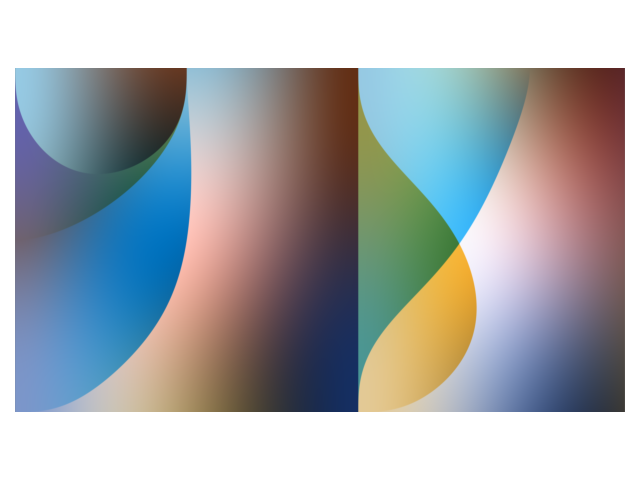

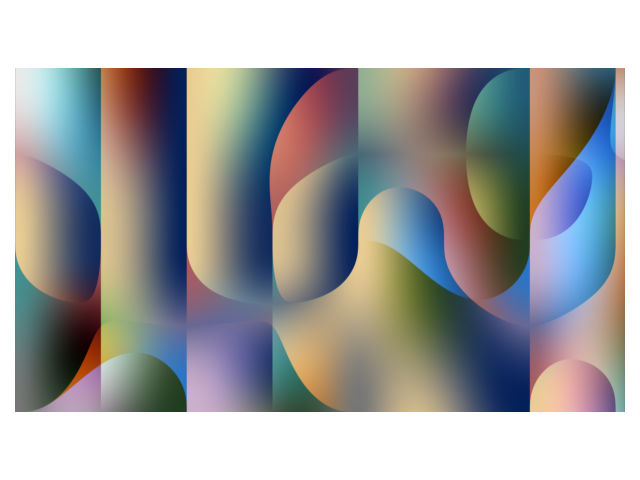

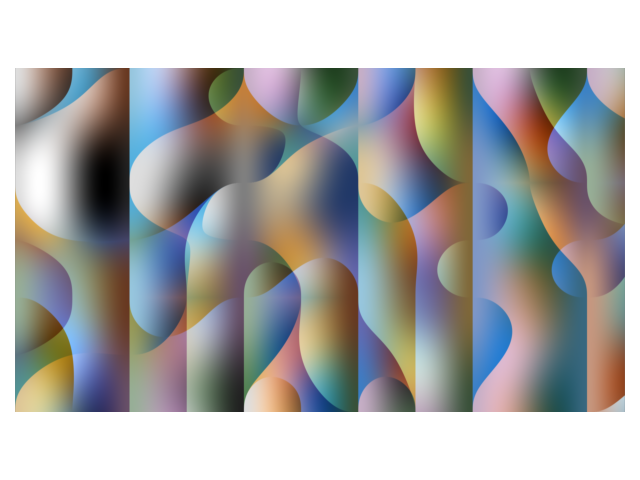

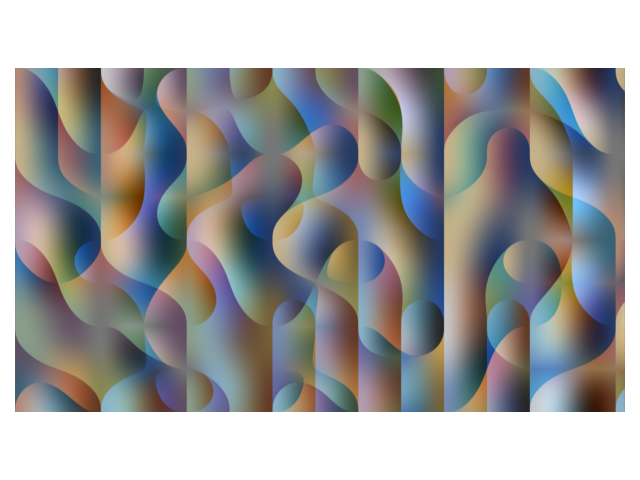

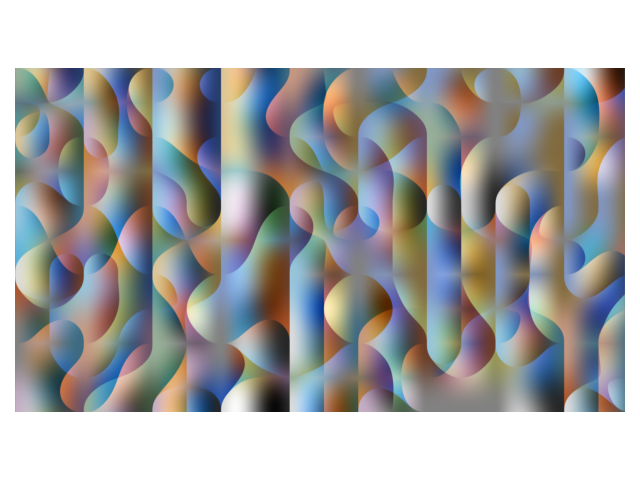

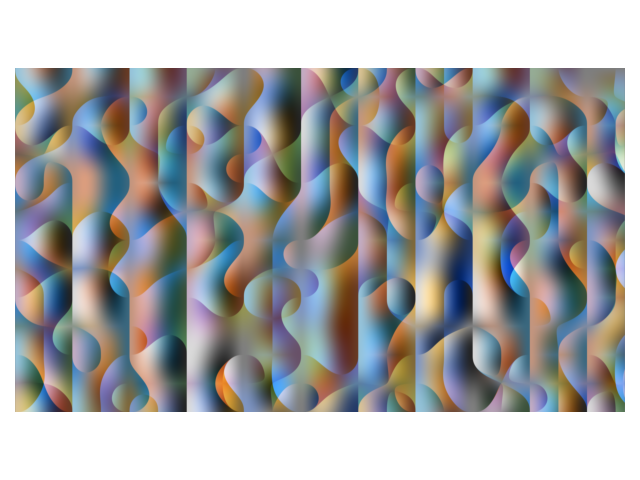

In [ ]:
# generate images! (these settings are particularly cool - feel free to remove these 
# from the arguments to generate() to get more variety!) we can actually combine the 
# settings of the generate() function with the settings of the loop that calls it (below)):
width, height = (1920, 1080)
num_images = 10
settings = {
    'random_convolution' : False,
    'absolute_value' : True,
    'convolution' : True,
    'convolution_filter' : top_sobel,
    'normalize_output' : True,
    'show_images' : True, 
    'save_images' : False, 
    'save_zip' : False
}

# let's make some cool images! notice that we can, for example, make the image 
# complexity dependent on i (i.e., i/10 gives cool results!)
with ZipFile('images.zip', 'w') as z:
    for i in range(1, num_images + 1):
        image = generate(height, width, k=20, complexity=i, settings=settings)
        
        if settings.get('show_images', True):
            plt.imshow(image)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

        if settings.get('save_images', False):
            plt.imsave('./image_%03d.png' % i, image)

        if settings.get('save_zip', False):
            z.write('image_%03d.png' % i)